## Load/Clean Data

Sources:

https://www.basketball-reference.com/players/

**Scrape multiple seasons**

In [425]:
import pandas as pd

PlayerID = "h/halibty01"

def scrape_season_data(season):
    url = f'https://www.basketball-reference.com/players/{PlayerID}/gamelog/{season}'
    print(f'Scraped from url: {url}')

    html = pd.read_html(url, header=0)
    scraped_data = html[7]

    return scraped_data

# Main loop to scrape data for multiple seasons
all_data = pd.DataFrame()  # Master DataFrame to store all seasons

seasons_to_scrape = ['2022', '2023', '2024']  # which seasons to scrape

for i in seasons_to_scrape:
    season_data = scrape_season_data(i)
    all_data = pd.concat([all_data, season_data], ignore_index=True)


pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

df = all_data.reset_index(drop=True)
all_data

Scraped from url: https://www.basketball-reference.com/players/h/halibty01/gamelog/2022
Scraped from url: https://www.basketball-reference.com/players/h/halibty01/gamelog/2023
Scraped from url: https://www.basketball-reference.com/players/h/halibty01/gamelog/2024


,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1,2021-10-20,21-233,SAC,@,POR,W (+3),1,28:36,...,2,2,4,1,0,1,2,2,1.5,+8
1,2,2,2021-10-22,21-235,SAC,NaN,UTA,L (-9),1,35:01,...,3,3,6,3,1,2,0,15,16.2,-17
2,3,3,2021-10-24,21-237,SAC,NaN,GSW,L (-12),1,29:52,...,6,7,9,0,2,2,1,8,10.7,-2
3,4,4,2021-10-27,21-240,SAC,@,PHO,W (+3),1,34:59,...,2,2,3,2,1,1,2,15,13.3,-1
4,5,5,2021-10-29,21-242,SAC,@,NOP,W (+4),1,31:22,...,2,2,8,0,1,2,0,17,15.9,+2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,31,28,2023-12-30,23-304,IND,NaN,NYK,W (+14),1,35:43,...,4,5,23,2,1,2,0,22,32.0,+19
204,32,29,2024-01-01,23-306,IND,@,MIL,W (+9),1,36:44,...,8,9,11,1,1,2,0,26,25.5,-5
205,33,30,2024-01-03,23-308,IND,NaN,MIL,W (+12),1,33:51,...,2,2,12,1,3,0,1,31,32.7,+21
206,34,31,2024-01-05,23-310,IND,NaN,ATL,W (+34),1,25:12,...,7,8,18,2,1,2,1,10,23.1,+24


**Checking for games where they didn't play**

In [426]:
inactive_rows = df[df['GS'].isin(['Inactive', 'Did Not Dress', "Did Not Play"])]
print("Number of rows with 'Inactive' or 'Did Not Dress/Play' in 'GS':", len(inactive_rows))

Number of rows with 'Inactive' or 'Did Not Dress/Play' in 'GS': 34


**Data cleaning**

In [427]:
import numpy as np

df = df.drop(df[df.G == "G"].index)                          # deletes repeating headers in content
df = df.drop(inactive_rows.index)                            # deletes rows/games where he was inactive

df.rename(columns={'Rk': 'SeasonGame',                          
                   'Unnamed: 5': 'LastHome',
                   'PTS': 'LastPTS',                         # renames columns to mean previous game stats
                   'GmSc': 'LastGmSc',
                   'MP': 'MPLast'}, inplace=True)            

df = df.drop(columns=['SeasonGame',                          # deletes useless columns
                      'Date',                                
                      'G', # which game played in                                
                      'Tm', # team they play for
                      'Unnamed: 7',
                      'Age',
                      'GS', # did they start the game
                      'PF', # personal fouls
                      '+/-'])

df['LastHome'].replace({np.nan: '0', '@': '1'}, inplace=True)       # reformats "Home" values
df['MPLast'] = pd.to_datetime(df['MPLast'], format='%M:%S').dt.minute   # turns MPLast into a datetime type and rounds to nearest minute
df.fillna(0, inplace=True)                                      # replaces NaN with 0
df = df.reset_index(drop=True)                                  # resets index

df

,LastHome,Opp,MPLast,FG,FGA,FG%,3P,3PA,3P%,FT,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,LastPTS,LastGmSc
0,1,POR,28,1,5,.200,0,1,.000,0,...,0,0,2,2,4,1,0,1,2,1.5
1,0,UTA,35,7,12,.583,0,2,.000,1,...,1.000,0,3,3,6,3,1,2,15,16.2
2,0,GSW,29,3,9,.333,2,6,.333,0,...,0,1,6,7,9,0,2,2,8,10.7
3,1,PHO,34,6,11,.545,2,5,.400,1,...,1.000,0,2,2,3,2,1,1,15,13.3
4,1,NOP,31,7,12,.583,1,2,.500,2,...,.667,0,2,2,8,0,1,2,17,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0,NYK,35,8,17,.471,2,10,.200,4,...,1.000,1,4,5,23,2,1,2,22,32.0
161,1,MIL,36,11,22,.500,1,7,.143,3,...,1.000,1,8,9,11,1,1,2,26,25.5
162,0,MIL,33,10,20,.500,5,11,.455,6,...,1.000,0,2,2,12,1,3,0,31,32.7
163,0,ATL,25,4,6,.667,2,4,.500,0,...,0,1,7,8,18,2,1,2,10,23.1


**Additional cleaning of data**

**creating columns that average stats from last 5 games**


In [428]:
# .rolling() creates a rolling window of size 5, considering at least 1 value to calculate the average.
df['avgPTSLast5'] = df['LastPTS'].rolling(window=5, min_periods=1).mean()      # average points from last 5 games
df['variancePTSLast5'] = df['LastPTS'].rolling(window=5, min_periods=1).std()      # STD of points from last 5 games

df['NextOpp'] = df['Opp'].shift(-1)                             # Shift 'Opp' values down by one and assign to 'NextOpp' etc
df['NextHome'] = df['LastHome'].shift(-1)
df['NextPTS'] = df['LastPTS'].shift(-1)

df = df.drop(columns=['Opp', 'NextOpp'])                        # removing oppositions (categorical) and instead trying historical opponent data

# need to implement numerical data about Opp here


mostRecentGame = df.iloc[-1:]                                   # keeps the last row for prediction later as "blind" dataset
df = df.drop(df.index[-1])                                      # drops the last row because the predictor variable (NextPTS) is 0 so that could mess up the training
df = df.drop([0, 1])                                            # drops first two rows because variancePTSLast5 is NaN & 0.00 due to no prior data to calculate STD

df

,LastHome,MPLast,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,AST,STL,BLK,TOV,LastPTS,LastGmSc,avgPTSLast5,variancePTSLast5,NextHome,NextPTS
2,0,29,3,9,.333,2,6,.333,0,0,...,9,0,2,2,8,10.7,8.333333,6.506407,1,15
3,1,34,6,11,.545,2,5,.400,1,1,...,3,2,1,1,15,13.3,10.000000,6.271629,1,17
4,1,31,7,12,.583,1,2,.500,2,3,...,8,0,1,2,17,15.9,11.400000,6.268971,1,14
5,1,33,5,14,.357,1,4,.250,3,3,...,4,0,2,1,14,12.0,13.800000,3.420526,1,14
6,1,31,6,16,.375,1,3,.333,1,2,...,3,1,2,1,14,8.8,13.600000,3.361547,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1,37,7,17,.412,6,13,.462,1,2,...,20,2,1,0,21,28.3,23.800000,6.870226,0,22
160,0,35,8,17,.471,2,10,.200,4,4,...,23,2,1,2,22,32.0,24.400000,6.465292,1,26
161,1,36,11,22,.500,1,7,.143,3,3,...,11,1,1,2,26,25.5,26.200000,4.969909,0,31
162,0,33,10,20,.500,5,11,.455,6,6,...,12,1,3,0,31,32.7,26.600000,5.319774,0,10


**Last step of cleaning data**: changing variable types

In [429]:
# Convert multiple columns to numeric
columns_to_convert = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 
                      'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
                      'STL', 'BLK', 'TOV', 'LastPTS', 
                      'LastGmSc', 'NextPTS', 'LastHome', 'NextHome']

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0)

#print(df.dtypes)

## Correlation Analysis of variables

correlation coefficients closer to 0 may contribute less or none at all to the prediction. If negative, it has an inverse relationship

In [430]:
correlation_matrix = df.corr()
correlations = correlation_matrix['NextPTS'].sort_values(ascending=False)
pd.DataFrame(correlations)
correlations

NextPTS             1.000000
avgPTSLast5         0.336226
FGA                 0.320132
LastPTS             0.247552
FG                  0.246521
FT%                 0.196688
FT                  0.196010
AST                 0.193176
LastGmSc            0.192772
FTA                 0.184273
variancePTSLast5    0.181004
3PA                 0.178478
DRB                 0.085128
3P                  0.078630
MPLast              0.075435
FG%                 0.039187
TOV                 0.015959
TRB                -0.008262
LastHome           -0.013374
NextHome           -0.022265
BLK                -0.046186
3P%                -0.054241
STL                -0.158843
ORB                -0.204116
Name: NextPTS, dtype: float64

## Feature Importance (Run this)

Check those importance scores to understand which features have a higher impact on predictions. 

This cell must be run because the X and y dataframes are created here and may be altered in the next cell to remove columns before training

In [431]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop(['NextPTS'], axis=1)
y = df['NextPTS']

model = RandomForestRegressor()
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_importances


avgPTSLast5         0.142238
variancePTSLast5    0.106625
FGA                 0.089593
FG%                 0.071924
LastGmSc            0.054158
3P%                 0.053868
AST                 0.052130
3PA                 0.045948
DRB                 0.043402
FTA                 0.041753
ORB                 0.035423
MPLast              0.034322
LastPTS             0.031189
STL                 0.029796
FG                  0.024370
TOV                 0.024343
TRB                 0.021078
3P                  0.020720
LastHome            0.019665
BLK                 0.016988
FT%                 0.015703
FT                  0.013498
NextHome            0.011265
dtype: float64

### OPTIONAL: 

remove certain columns if they may be causing excess noise, which may lead to poor generalization and overfitting (do it above and rerun)

## Random Forest

In [432]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd


# Separation is done in the Feature Importance cell
# X = df.drop("NextPTS", axis=1)
# y = df['NextPTS']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predictions
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)


### SKIP THIS IF RAN ABOVE

This is a **more advanced** random forest regressor that uses hyperparamters, takes longer to load, needs good gpu

**n_estimators**: The number of trees in the forest. Increasing the number of trees generally helps, but it may also lead to longer training times.

**max_depth**: The maximum depth of each tree in the forest. Controlling the depth can help prevent overfitting.

**min_samples_split**: The minimum number of samples required to split an internal node. Increasing this parameter can lead to a more robust model.

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. Similar to min_samples_split, increasing this parameter can prevent overfitting.

**max_features**: The number of features to consider when looking for the best split. Limiting the number of features considered can be useful to reduce overfitting.

In [359]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd


# Separation is done in the Feature Importance cell
# X = df.drop("NextPTS", axis=1)
# y = df['NextPTS']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
    }

# Create a RandomForestRegressor
rf = RandomForestRegressor()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a Random Forest Regressor with the best hyperparameters
best_rf = RandomForestRegressor(**best_params)

# Fit the model on the training data
best_rf.fit(X_train, y_train)

# Predictions
y_rf_train_pred = best_rf.predict(X_train) # this is predictions for the train set, which its already seen, so kinda useless. only for comparing the MSE
y_rf_test_pred = best_rf.predict(X_test)

/Users/chaddiao/Desktop/ML_NBA_App/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
149 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chaddiao/Desktop/ML_NBA_App/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chaddiao/Desktop/ML_NBA_App/venv/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/chaddiao/Desktop/ML_NBA_App/venv/lib/python3.9/site-packages/sklearn/base.py", line 638, in 

## Actually Predicting


In [433]:
from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

In [434]:
rf_results = pd.DataFrame(["Random Forest", rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ["Method", "Training MSE", "Training R2", "Test MSE", "Test R2"]
rf_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random Forest,9.261379,0.857883,92.455727,-0.103586


In [456]:
X_new = df.loc[[112]]
#X_new = mostRecentGame.assign(NextHome=0)
X_new

,LastHome,MPLast,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,AST,STL,BLK,TOV,LastPTS,LastGmSc,avgPTSLast5,variancePTSLast5,NextHome,NextPTS
112,0,31,7,15,0.467,2,4,0.5,0,0,...,8,2,0,7,16,10.3,20.8,6.760178,1,16


In [457]:
# Ensure that X_new has the same order of columns as X used during training
X_new = X_new[X.columns]

next_game_prediction = rf.predict(X_new)

# Make predictions using the trained model w/ HYPERPARAMETERS
#next_game_predictions = best_rf.predict(X_new)

# Display
print("Predicted Points for Next Game:", next_game_prediction)


Predicted Points for Next Game: [16.91]


## Confidence Score 

check confidence of predicted score (i dont understand how bootstrapping works rn)

In [458]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Number of bootstrap samples
n_bootstrap_samples = 100

# Perform bootstrapping
bootstrap_predictions = []
for _ in range(n_bootstrap_samples):
    # Create a bootstrap sample
    bootstrap_sample_indices = np.random.choice(len(X), len(X), replace=True)
    X_bootstrap = X.iloc[bootstrap_sample_indices]

    # Make predictions on the bootstrap sample
    bootstrap_predictions.append(rf.predict(X_bootstrap))

# Calculate confidence interval
confidence_level = 0.75     # 75% confident it will fall in this interval
lower_bound = np.percentile(bootstrap_predictions, (1 - confidence_level) / 2 * 100, axis=0)    #contains the lower bounds of the 95% confidence intervals for each prediction made by your model
upper_bound = np.percentile(bootstrap_predictions, (1 + confidence_level) / 2 * 100, axis=0)
cWidth = round(upper_bound[0] - lower_bound[0], 2)


# Display predictions and confidence interval
print("Predicted Points for Next Game:", next_game_prediction)
print("Confidence Interval: [{:.2f}, {:.2f}]".format(lower_bound[0], upper_bound[0]) + f" | Width: {cWidth}")
if cWidth < 6:
    print(f"Low Width, High Confidence: {confidence_level * 100}% confident the true value is within above intervals")
elif 6 <= cWidth < 11:
    print(f"Moderate Width, Medium Confidence: {confidence_level * 100}% confident the true value is within above intervals")
else:
    print(f"Large Width, Low Confidence: {confidence_level * 100}% confident the true value is within above intervals")


Predicted Points for Next Game: [16.91]
Confidence Interval: [15.59, 25.36] | Width: 9.77
Moderate Width, Medium Confidence: 75.0% confident the true value is within above intervals


## Assessing residuals 

to understand where the model performs well and where it sucks

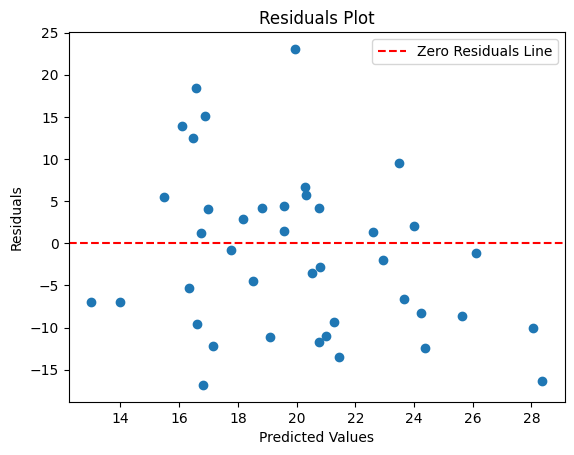

In [439]:
import matplotlib.pyplot as plt

predicted_values = y_rf_test_pred
actual_values = y_test

# Calculate residuals
residuals = actual_values - predicted_values

# Scatter plot of residuals
plt.scatter(predicted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residuals Line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.show()



### <span style="text-decoration: underline;">Reading the graph:</span>

**Red Line (Zero Residuals Line)**: 
- The red dashed line at y=0 represents where the residuals would be if the model's predictions were perfect.
- Ideally, you want the blue dots (residuals) to be scattered randomly around this line, indicating that, on average, the model's predictions are unbiased.

**Blue Dots (Residuals)**: 
- Each blue dot represents the difference between the actual value and the predicted value for a specific data point. 
- If a dot is above the red line, it means the model underpredicted that particular point. If below, it means the model overpredicted.

### <span style="text-decoration: underline;">Interpretations:</span>

**Systematic Patterns**:
- If you observe a clear pattern (e.g., all dots increasing or decreasing systematically), it indicates a potential issue with bias in the model. 
- For example, if residuals tend to increase with the predicted values, the model might be consistently underpredicting high values.

**Heteroscedasticity**:

- If the spread of residuals varies across the predicted values, it indicates heteroscedasticity. 
- In other words, the model's performance might be inconsistent across different ranges of predicted values.

**Outliers**:
- Look for outliers—individual data points with unusually large residuals. These points might have a significant impact on the model's overall performance.

**Here are some common patterns and what they might suggest**:
- Good Scenario: Random scatter, no clear pattern, and no outliers.
- Bad Scenario: Systematic pattern, non-random spread, or outliers.

## One hot encoding explained

Takes a column which has categorical data, which has been label encoded and then splits the column into multiple columns. The numbers are replaced by 1s and 0s, depending on which column has what value.

This is better than label encoding because since there are different numbers in the same column, the model will misunderstand the data to be in some kind of order, 0 < 1 < 2

![Example One Hot Encoding](Data/one_hot_encoding_example.png)

# Decision Tree Classifier


In [347]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Convert points to categories
# Example: 0-5 points, 6-10 points, 11-15 points, and so on
bins = [-1, 5, 10, 15, 20, 25, 30, 35, 40, 45, float('inf')]
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46+']

# Step 2: Modify the target variable in the original DataFrame
df['PointsCategory'] = pd.cut(df['NextPTS'], bins=bins, labels=labels, right=False)

# Step 2: Apply one-hot encoding to the categorical columns in the entire DataFrame
categorical_columns = []
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Step 3: Split data into features (X) and the new categorical target variable (y)
X = df_encoded.drop(['NextPTS', 'PointsCategory'], axis=1)
y = df_encoded['PointsCategory']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Step 6: Make Predictions
predictions = dt_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.17647058823529413

Classification Report:
               precision    recall  f1-score   support

         0-5       0.00      0.00      0.00         1
       11-15       0.00      0.00      0.00         3
       16-20       0.20      0.17      0.18         6
       21-25       0.17      0.50      0.25         2
       26-30       0.00      0.00      0.00         1
       31-35       1.00      0.33      0.50         3
       41-45       0.00      0.00      0.00         1
        6-10       0.00      0.00      0.00         0

    accuracy                           0.18        17
   macro avg       0.17      0.12      0.12        17
weighted avg       0.27      0.18      0.18        17



/Users/chaddiao/Desktop/ML_NBA_App/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaddiao/Desktop/ML_NBA_App/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaddiao/Desktop/ML_NBA_App/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

In [348]:
predResults = pd.DataFrame({'y_test': y_test, 'predictions': predictions})
predResults['correct'] = predResults['y_test'] == predResults['predictions']
predResults

,y_test,predictions,correct
80,31-35,16-20,False
2,16-20,16-20,True
70,41-45,26-30,False
24,0-5,11-15,False
14,16-20,6-10,False
84,31-35,31-35,True
12,16-20,21-25,False
20,11-15,21-25,False
6,11-15,16-20,False
68,26-30,41-45,False
